# In the name of God

# Prepare libraries

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda


# Supervised

<div dir=rtl>

## آ ) لود کردن دیتاست

In [ ]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1,), std=(0.2,)),
    transforms.Lambda(lambda x: x.view(-1))
])
train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=60000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=10000, shuffle=False)

100%|██████████| 9912422/9912422 [00:00<00:00, 70082093.25it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 102138021.77it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 81121971.03it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 19639720.38it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



<div dir=rtl>

## ب ) تولید داده

In [ ]:
def label_on_image(data, labels):
    labeled = torch.clone(data)
    labeled[:, :10] = 0.0
    max_vals = torch.max(data, dim=1).values
    labeled[torch.arange(data.size(0)), labels] = max_vals
    return labeled
images, labels = next(iter(train_loader))
images, labels = images.cuda(), labels.cuda()

pos_labeled_t = label_on_image(images, labels)
rnd_indices = torch.randperm(images.size(0))
neg_labeled_t = label_on_image(images, labels[rnd_indices])

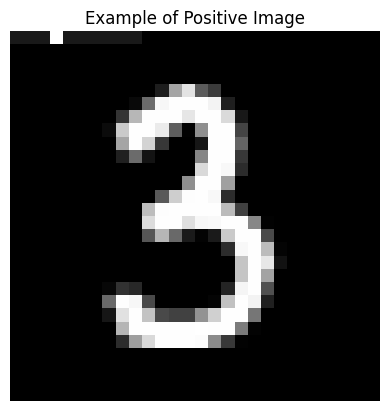

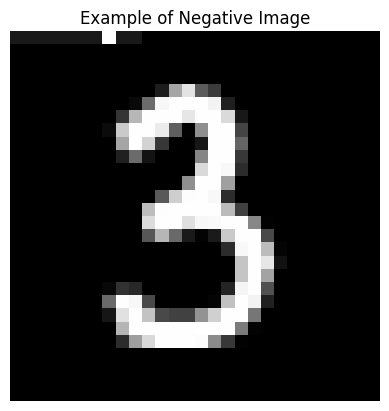

In [ ]:
import matplotlib.pyplot as plt

x= pos_labeled_t[600]
x=x.cpu()
x=x.reshape([28,28])
img = x.squeeze().numpy()
plt.imshow(img, cmap='gray')
plt.title('Example of Positive Image')
plt.axis('off')
plt.show()

x_neg=neg_labeled_t[600]
x_neg=x_neg.cpu()
x_neg=x_neg.reshape([28,28])
img = x_neg.squeeze().numpy()
plt.imshow(img, cmap='gray')
plt.title('Example of Negative Image')
plt.axis('off')
plt.show()

<div dir=rtl>

## ج ) پیاده سازی شبکه

In [ ]:
class Layer(nn.Module):
    def __init__(self, input_size, output_size, use_bias=True):
        super(Layer, self).__init__()
        self.threshold = 2.0
        self.training_epochs = 3000
        self.linear_transformation = nn.Linear(input_size, output_size, bias=use_bias)
        self.optimizer = optim.Adam(self.parameters(), lr=0.06)
        self.activation = nn.ReLU()

    def forward(self, input_data):
        normalized_input = input_data / (input_data.norm(2, dim=1, keepdim=True) + 1e-4)
        return self.activation(
            torch.mm(normalized_input, self.linear_transformation.weight.T) + self.linear_transformation.bias.unsqueeze(0)
        )

    def train(self, positive_data, negative_data):
        for epoch in range(self.training_epochs):
            goodness_pos = self.forward(positive_data).pow(2).mean(1)
            goodness_neg = self.forward(negative_data).pow(2).mean(1)

            loss = torch.log(1 + torch.exp(
                torch.cat([-goodness_pos + self.threshold, goodness_neg - self.threshold]))
            ).mean()

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if epoch % 300 ==0:

                print(f"Epoch [{epoch}/{self.training_epochs}] Loss: {loss.item()}")

        return self.forward(positive_data).detach(), self.forward(negative_data).detach()

<div dir=rtl>

## د ) آموزش شبکه و گزارش نتایج

In [ ]:
torch.manual_seed(1234)
dims = [784, 550, 300]
net_layers = []
N = len(dims) - 1

for i in range(N):
    net_layers.append(Layer(dims[i], dims[i + 1]).cuda())

pos_labeled=pos_labeled_t
neg_labeled=neg_labeled_t

for i,layer in enumerate(net_layers):
    pos_labeled, neg_labeled = layer.train(pos_labeled, neg_labeled)
    print('training layer', i,)

train_errors = []
for lbl in range(10):
    goodness = []
    lbl_img = label_on_image(images, lbl)
    for layer in net_layers:
        lbl_img = layer(lbl_img)
        goodness.append(lbl_img.pow(2).mean(1))
    train_errors.append(sum(goodness).unsqueeze(1))
train_errors = torch.cat(train_errors, 1)
predicted_train_labels = train_errors.argmax(1)

print('Train error:', 1.0 - predicted_train_labels.eq(labels).float().mean().item())

test_images, test_labels = next(iter(test_loader))
test_images, test_labels = test_images.cuda(), test_labels.cuda()

test_errors = []
for lbl in range(10):
    goodness = []
    lbl_img_test = label_on_image(test_images, lbl)
    for layer in net_layers:
        lbl_img_test = layer(lbl_img_test)
        goodness.append(lbl_img_test.pow(2).mean(1))
    test_errors.append(sum(goodness).unsqueeze(1))
test_errors = torch.cat(test_errors, 1)
predicted_test_labels = test_errors.argmax(1)
print('Test error:', 1.0 - predicted_test_labels.eq(test_labels).float().mean().item())


Epoch [0/3000] Loss: 1.1267706155776978
Epoch [300/3000] Loss: 0.4465562403202057
Epoch [600/3000] Loss: 0.36124661564826965
Epoch [900/3000] Loss: 0.3230915367603302
Epoch [1200/3000] Loss: 0.29868900775909424
Epoch [1500/3000] Loss: 0.2807803452014923
Epoch [1800/3000] Loss: 0.2668926417827606
Epoch [2100/3000] Loss: 0.2553298771381378
Epoch [2400/3000] Loss: 0.24497714638710022
Epoch [2700/3000] Loss: 0.23535799980163574
training layer 0
Epoch [0/3000] Loss: 1.1266586780548096
Epoch [300/3000] Loss: 0.30157271027565
Epoch [600/3000] Loss: 0.2858760356903076
Epoch [900/3000] Loss: 0.2766282856464386
Epoch [1200/3000] Loss: 0.2691710293292999
Epoch [1500/3000] Loss: 0.2624545097351074
Epoch [1800/3000] Loss: 0.2559850811958313
Epoch [2100/3000] Loss: 0.24986377358436584
Epoch [2400/3000] Loss: 0.24392102658748627
Epoch [2700/3000] Loss: 0.2381117194890976
training layer 1
Train error: 0.026466667652130127
Test error: 0.03750002384185791


<div dir=rtl>
ابتدا لیبل هر تصویر را در ده پیکسل ابتدایی آن به صورت one-hot قرار میدهیم
حال کلاس layer را تعریف کرده که تنظیمات مورد نیاز آن جمله بهینه ساز را مطابق مطالب گفته شده در مقاله قرار می دهیم
سپس تابع فوروارد را در این کلاس تعریف میکنیم که از تابع ReLu وترکیب خطی ورودی استفاده می کند.
سپس خروجی این فوروارد را به عنوان goodness تعریف میکنیم.
در مورد سوال پرسیده شد برای تابع لاس میتوان بیان کرد که هر چقدر goodnessبرای تصاویر مثبت بیشتر باشد مقدار loss کاهش میابد و برای تصاویر منفی برعکس

این پیاده سازی با کمک https://github.com/mpezeshki/pytorch_forward_forward انجام شده است.
البته خطای ما با تغییراتی که داده ایم نصف ایشان است.